# <center><u>**PROJET BIG DATA - WHO ARE THE HFT?**</u></center>
### <center>**AMF CHALLENGE**</center>

### <u>1- Importation des librairies<u>

In [570]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB

### <u>2- Importation de la base de données et regroupement de Y et X <u>

In [571]:
df_x=pd.read_csv("AMF_train_X.csv")
df_y=pd.read_csv("AMF_train_Y.csv")
df=pd.merge(df_y,df_x,on="Trader")
df1=df.drop(['Index','Share','Day'],axis=1) # ces variables ne servent à rien ( le num du trader est aussi inutil mais on va
                                            # le garder parce qu'on en aura besoin pour le regroupement )
df1.head()

,Trader,type,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,...,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade
0,Trader_285,MIX,1.428571,10.0,NaN,0.000,2.013731,0.000,0.000000,0.000,...,0.018,420.371000,51.083,0.017,17.039333,0.018,0.018,17.039667,0.018,52
1,Trader_285,MIX,NaN,2.0,NaN,21258.127,21258.126953,21258.127,21258.127000,21258.127,...,0.021,13.355429,0.644,0.021,20.416500,0.021,0.021,20.416500,0.021,14
2,Trader_285,MIX,1.500000,7.0,NaN,0.000,4269.648575,0.000,651.518100,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Trader_285,MIX,1.050633,83.0,NaN,0.000,1.728176,0.000,0.000435,0.000,...,65.660,65.660000,65.660,65.660,65.660000,65.660,65.660,65.660000,65.660,82
4,Trader_285,MIX,NaN,2.0,NaN,21261.256,21261.255859,21261.256,21261.256000,21261.256,...,0.020,2.687125,0.021,0.020,3.676200,0.021,0.020,16.099333,0.021,12


### <u>2- Train/Test Split <u> 

Nous allons diviser le dataset avant de faire le nettoyage des données pour éviter le data leakage : le nettoyage sera fait 
d'abord sur le training set et les valeurs utilisées pour le remplacement des valeurs manquantes seront après utilisées dans le 
nettoyage du testing set

In [572]:
#split train/test
df_train,df_test=train_test_split(df1,test_size=0.25, random_state=1,shuffle=True ) 
df_train.head()

,Trader,type,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,...,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade
62733,Trader_380,NON HFT,4.125000,24.000000,20.307692,0.000000,6003.961542,0.000000,176.227870,6.569422,...,1053.639566,1053.639566,1053.639566,1053.639566,1053.639566,1053.639566,1053.639566,1053.639566,1053.639566,45
50820,Trader_105,NON HFT,3.809524,40.000000,NaN,0.000000,1704.873301,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
93570,Trader_35,HFT,NaN,3.000000,NaN,0.000006,47.766374,0.000006,0.000008,0.000007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
48863,Trader_329,MIX,38.200000,2.139795,1464.333333,0.000000,68.687286,1.204900,19.578550,5.569770,...,0.000004,45.908919,0.463846,0.000002,87.689266,19.777873,0.000004,51.189014,7.931105,246
98266,Trader_451,MIX,131.000000,3.184765,2.795164,0.000000,45.247940,0.023045,12.952679,1.568145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


### <u>3- Data Cleaning <u>

In [573]:
# déterminer pour chaque variable le nbre de valeurs manquantes et leur part dans le total des observations ( sur le training set )
nb_NaN=df_train.drop(['Trader'],axis=1).isnull().sum().sort_values(ascending=False)
df_null=pd.DataFrame({'nbre de NaN' : nb_NaN,'% des NaN':round((nb_NaN/df1.shape[0])*100)})
df_null

,nbre de NaN,% des NaN
OMR,35710,34.0
med_dt_TV1_TV3,18974,18.0
mean_dt_TV1_TV3,18974,18.0
min_dt_TV1_TV3,18974,18.0
med_dt_TV1_TV2,18917,18.0
mean_dt_TV1_TV2,18917,18.0
min_dt_TV1_TV2,18917,18.0
med_dt_TV1_TV4,18900,18.0
mean_dt_TV1_TV4,18900,18.0
min_dt_TV1_TV4,18900,18.0


#### <font color='red'><u>Commentaire</u></font> :  Un peu moins que la moitié des valeurs de la variable OMR sont manquantes mais on va garder cette variable car , à priori ,elle semble importante ( à vérifier dans la partie Feature selection ) . Elle traduit le % d'évènements de type modification de l'ordre qui semble justifier en partie le type du trader . 
#### --> on va procéder (aussi bien pour la variable OMR que OTR) à un remplacement par la moyenne .

#### - <u>Traiter les valeurs manquantes des variables OMR et OTR</u>

In [574]:
moy_stockés1=df_train[['OMR','OTR']].mean()  #on stocke les moyennes du training set pour les remplacer après dans le testing set
df_train[['OMR','OTR']]=df_train[['OMR','OTR']].fillna(moy_stockés1)

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\core\frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [575]:
#on remplace par les moyennes du training set dans le testing set
df_test[['OMR','OTR']]=df_test[['OMR','OTR']].fillna(moy_stockés1) 

In [576]:
df_train.isnull().sum()

Trader                            0
type                              0
OTR                               0
OCR                               0
OMR                               0
min_time_two_events               0
mean_time_two_events              0
10_p_time_two_events              0
med_time_two_events               0
25_p_time_two_events              0
75_p_time_two_events              0
90_p_time_two_events              0
max_time_two_events               0
min_lifetime_cancel               0
mean_lifetime_cancel              0
10_p_lifetime_cancel              0
med_lifetime_cancel               0
25_p_lifetime_cancel              0
75_p_lifetime_cancel              0
90_p_lifetime_cancel              0
max_lifetime_cancel               0
NbTradeVenueMic                   0
MaxNbTradesBySecond               0
MeanNbTradesBySecond              0
min_dt_TV1                     3191
mean_dt_TV1                    3191
med_dt_TV1                     3191
min_dt_TV1_TV2              

#### - <u>Traiter les autres valeurs manquantes</u>

Vu que le temps entre 2 trades du TV1 puis du TV2 , ou du TV1 puis du TV3 , ou du TV1 puis du TV4 traduisent la même information
à savoir le temps entre 2 trades de 2 trading venues différentes , on a décidé d'agréger les variables 
<font color='red'>**[ 'min_dt_TV1_TV2','mean_dt_TV1_TV2', 'med_dt_TV1_TV2', 'min_dt_TV1_TV3','mean_dt_TV1_TV3', 'med_dt_TV1_TV3', 'min_dt_TV1_TV4',
'mean_dt_TV1_TV4', 'med_dt_TV1_TV4' ]**</font> de la facon suivante :

min_dt_TV1_TV2 / min_dt_TV1_TV3 / min_dt_TV1_TV4 **-->** moyenne : le temps minimum moyen entre 2 trades de 2 venues différentes

med_dt_TV1_TV2 / med_dt_TV1_TV3 / med_dt_TV1_TV4 **-->** moyenne : le temps médian moyen entre 2 trades de 2 venues différentes

mean_dt_TV1_TV2 / mean_dt_TV1_TV3 / mean_dt_TV1_TV4 **-->** moyenne : la moyenne du temps moyen entre 2 trades de 2 venues différentes

*Autre le fait que ces 9 variables traduisent la même information , On les agrège aussi dans une tentative de réduire les valeurs manquantes ( la moyenne de 1 NaN et 2 valeurs non NaN donnent une valeur non NaN ) 

In [577]:
# Pour confirmer le fait que les 2 trades du TV1 puis du TV2 , ou du TV1 puis du TV3 , ou du TV1 puis du TV4 
# traduisent la même information : leur corrélation est très forte > 0.9
print(df_train[['min_dt_TV1_TV2','min_dt_TV1_TV3','min_dt_TV1_TV4']].corr(),
      df_train[['mean_dt_TV1_TV2','mean_dt_TV1_TV3','mean_dt_TV1_TV4']].corr() 
      , df_train[['mean_dt_TV1_TV2','mean_dt_TV1_TV3','mean_dt_TV1_TV4']].corr() )

                min_dt_TV1_TV2  min_dt_TV1_TV3  min_dt_TV1_TV4
min_dt_TV1_TV2        1.000000        0.957061        0.946751
min_dt_TV1_TV3        0.957061        1.000000        0.967721
min_dt_TV1_TV4        0.946751        0.967721        1.000000                  mean_dt_TV1_TV2  mean_dt_TV1_TV3  mean_dt_TV1_TV4
mean_dt_TV1_TV2         1.000000         0.976354         0.968322
mean_dt_TV1_TV3         0.976354         1.000000         0.979244
mean_dt_TV1_TV4         0.968322         0.979244         1.000000                  mean_dt_TV1_TV2  mean_dt_TV1_TV3  mean_dt_TV1_TV4
mean_dt_TV1_TV2         1.000000         0.976354         0.968322
mean_dt_TV1_TV3         0.976354         1.000000         0.979244
mean_dt_TV1_TV4         0.968322         0.979244         1.000000


In [578]:
# pour éviter de refaire le travail 2 fois , on définit une fct° . On appelera cette fct° sur le training et le testing set 
def moy_tvi_tvj(df):
    df['moy_min_dt_TVi_TVj']=df[['min_dt_TV1_TV2','min_dt_TV1_TV3','min_dt_TV1_TV4']].mean(axis=1)
    df['moy_med_dt_TVi_TVj']=df[['med_dt_TV1_TV2','med_dt_TV1_TV3','med_dt_TV1_TV4']].mean(axis=1)
    df['moy_mean_dt_TVi_TVj']=df[['mean_dt_TV1_TV2','mean_dt_TV1_TV3','mean_dt_TV1_TV4']].mean(axis=1)
    df=df.drop(['min_dt_TV1_TV2',
           'mean_dt_TV1_TV2', 'med_dt_TV1_TV2', 'min_dt_TV1_TV3',
           'mean_dt_TV1_TV3', 'med_dt_TV1_TV3', 'min_dt_TV1_TV4',
           'mean_dt_TV1_TV4', 'med_dt_TV1_TV4'],axis=1)
    return df

df_train=moy_tvi_tvj(df_train)
df_test=moy_tvi_tvj(df_test)
df_train.isnull().sum().sort_values(ascending=False)

C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

moy_mean_dt_TVi_TVj           18739
moy_med_dt_TVi_TVj            18739
moy_min_dt_TVi_TVj            18739
med_dt_TV1                     3191
mean_dt_TV1                    3191
min_dt_TV1                     3191
med_lifetime_cancel               0
NbSecondWithAtLeatOneTrade        0
MeanNbTradesBySecond              0
MaxNbTradesBySecond               0
NbTradeVenueMic                   0
max_lifetime_cancel               0
90_p_lifetime_cancel              0
75_p_lifetime_cancel              0
25_p_lifetime_cancel              0
Trader                            0
type                              0
mean_lifetime_cancel              0
min_lifetime_cancel               0
max_time_two_events               0
90_p_time_two_events              0
75_p_time_two_events              0
25_p_time_two_events              0
med_time_two_events               0
10_p_time_two_events              0
mean_time_two_events              0
min_time_two_events               0
OMR                         

Même avec l'aggrégation de ces 9 variables , les valeurs manquantes sont encore élevés (18739).  Les 3 variables dt_TVi_TVj 
traduisent une information importante (<font color='red'>à priori</font> ) : Les traders HFT tendent à effectuer des trades dans des différentes venues
dans un laps de temps plus court ( **la simultanéité ou quasi-simultanéité de 2 trades dans 2 places financières différentes
est une caractéristique probable des traders HFT** ) . 
Donc , on va garder les 3 variables dt_TVi_TVj ainsi que les variables : min_dt_TV1', 'mean_dt_TV1', 'med_dt_TV1'. On va 
procéder de la même manière pour le remplacement des valeurs manquantes . 

In [579]:
lst=list(df_train.columns)
lst_names=lst[-3:]+lst[-7:-4]
lst_names

['moy_min_dt_TVi_TVj',
 'moy_med_dt_TVi_TVj',
 'moy_mean_dt_TVi_TVj',
 'min_dt_TV1',
 'mean_dt_TV1',
 'med_dt_TV1']

In [580]:
moy_stockés2=df_train[lst_names].mean()  #on stocke les moyennes du training set pour les remplacer après dans le testing set
df_train[lst_names]=df_train[lst_names].fillna(moy_stockés2)
df_test[lst_names]=df_test[lst_names].fillna(moy_stockés2) #on remplace par les moyennes du training set

In [581]:
df_train.isnull().sum()

Trader                        0
type                          0
OTR                           0
OCR                           0
OMR                           0
min_time_two_events           0
mean_time_two_events          0
10_p_time_two_events          0
med_time_two_events           0
25_p_time_two_events          0
75_p_time_two_events          0
90_p_time_two_events          0
max_time_two_events           0
min_lifetime_cancel           0
mean_lifetime_cancel          0
10_p_lifetime_cancel          0
med_lifetime_cancel           0
25_p_lifetime_cancel          0
75_p_lifetime_cancel          0
90_p_lifetime_cancel          0
max_lifetime_cancel           0
NbTradeVenueMic               0
MaxNbTradesBySecond           0
MeanNbTradesBySecond          0
min_dt_TV1                    0
mean_dt_TV1                   0
med_dt_TV1                    0
NbSecondWithAtLeatOneTrade    0
moy_min_dt_TVi_TVj            0
moy_med_dt_TVi_TVj            0
moy_mean_dt_TVi_TVj           0
dtype: i

#### --> on n'a plus de valeurs manquantes

### <u>4- aggrégation de la base de données  <u>

In [582]:
#Aggrégation de la base de données : moyenne des observations par trader
df_train=df_train.groupby(['Trader']).mean().reset_index()

In [583]:
df_train=pd.merge(df_y,df_train,on='Trader')
df_train.head()

,Trader,type,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,...,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,NbSecondWithAtLeatOneTrade,moy_min_dt_TVi_TVj,moy_med_dt_TVi_TVj,moy_mean_dt_TVi_TVj
0,Trader_285,MIX,7.807554,34.600000,163.730280,8.951034,864.050787,8.951034,139.254886,8.951054,...,9.200000,17.400000,5.119288,87.691021,226.333150,130.584267,39.000000,139.513929,196.813139,430.459508
1,Trader_114,NON HFT,5.291763,26.348230,163.796670,281.143544,7327.222269,285.624589,1951.956669,497.031552,...,1.948348,14.722523,1.476684,118.461499,743.325773,400.064941,104.612012,250.939310,489.069498,796.776108
2,Trader_110,NON HFT,3.666667,9.142857,163.730280,1725.812961,14833.008158,1725.812961,3325.696247,1725.812961,...,1.000000,3.571429,2.428571,6455.785804,7946.697951,6578.318506,1.571429,311.478322,403.644681,613.857998
3,Trader_57,NON HFT,3.261453,11.372549,94.474854,341.188804,4456.655164,343.341275,601.566444,348.091122,...,1.000000,2.705882,1.899160,3193.790743,6042.941310,4087.296235,3.470588,311.478322,403.644681,613.857998
4,Trader_128,NON HFT,9.888919,12.624458,163.730280,3669.775350,9966.792043,3669.775354,5112.676497,3705.061185,...,1.419753,5.769547,1.862654,1173.328002,2680.564504,1545.688415,13.646091,1114.433802,1195.094042,1609.667081


In [584]:
df_test=df_test.groupby(['Trader']).mean().reset_index()
df_test=pd.merge(df_y,df_test,on='Trader')
df_test.head()

,Trader,type,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,...,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,NbSecondWithAtLeatOneTrade,moy_min_dt_TVi_TVj,moy_med_dt_TVi_TVj,moy_mean_dt_TVi_TVj
0,Trader_285,MIX,25.853940,7.250000,163.730280,15945.150000,15988.277334,15945.150005,15945.150112,15945.150019,...,8.000000,11.000000,4.109375,0.017000,64.014726,0.021500,35.000000,745.809667,745.864500,755.882771
1,Trader_114,NON HFT,5.330605,26.173368,163.730280,163.240074,7346.201169,165.405602,1885.117576,363.844437,...,1.969203,16.317029,1.479432,150.485179,705.924973,395.613114,107.835145,257.875933,480.769582,767.662607
2,Trader_110,NON HFT,2.400000,6.000000,163.730280,0.000000,15262.259766,0.000000,0.000000,0.000000,...,1.000000,4.000000,2.500000,604.070402,604.070402,604.070402,2.000000,311.478322,403.644681,613.857998
3,Trader_57,NON HFT,2.396578,18.055556,99.989045,0.281090,5183.910167,0.281090,711.692024,0.281333,...,1.000000,4.111111,2.013533,1372.979357,3086.425393,1960.297629,4.888889,311.478322,403.644681,613.857998
4,Trader_128,NON HFT,9.973350,11.503487,163.730280,3023.794192,8835.333871,3023.794193,5269.297803,3211.912981,...,1.464286,5.571429,1.603555,1371.379622,2991.888247,1791.915847,17.869048,1112.806234,1186.309211,1497.133224


In [585]:
#séparer la colonne du target de la matrice des variables explicatives + encoding de la colonne du target 
y_train=df_train['type'].replace({'HFT':0,'NON HFT':1,'MIX':2})
x_train=df_train.drop(['type','Trader'],axis=1) 
y_test=df_test['type'].replace({'HFT':0,'NON HFT':1,'MIX':2})
x_test=df_test.drop(['type','Trader'],axis=1)

 ### <u>5- Data exploration

<AxesSubplot:title={'center':'Distribution du Target'}, ylabel='% des traders'>

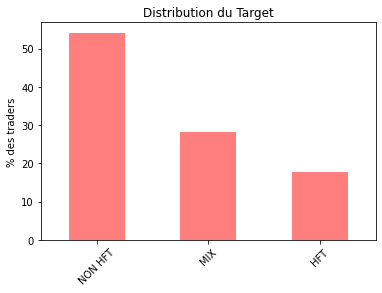

In [586]:
# Pour des raisons de visualisation , on va décoder les valeurs des classes : 
df_train_dec=df_train.replace({'type':{0:'HFT',1:'NON HFT',2:'MIX'}})
# visualisation de la distribution du target
plt.title('Distribution du Target')
plt.ylabel('% des traders')
(df_train_dec['type'].value_counts()/df_train_dec.shape[0]*100).plot.bar(rot=45,color='r',alpha=0.5)

### Statistiques descriptives :

In [587]:
df_train_dec[['type','OTR', 'OCR', 'OMR', 'mean_time_two_events', '90_p_time_two_events',
       '75_p_lifetime_cancel', '90_p_lifetime_cancel', 'NbTradeVenueMic',
        'MeanNbTradesBySecond', 'min_dt_TV1',
       'mean_dt_TV1', 'NbSecondWithAtLeatOneTrade']].groupby(['type']).mean()

,OTR,OCR,OMR,mean_time_two_events,90_p_time_two_events,75_p_lifetime_cancel,90_p_lifetime_cancel,NbTradeVenueMic,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,NbSecondWithAtLeatOneTrade
type,,,,,,,,,,,,
HFT,73.150343,31.947955,122.169833,872.861989,3252.076416,3742.003895,4802.965980,4.642871,2.442493,1140.896574,1878.587925,334.067432
MIX,16.248462,19.095098,181.528134,1270.441537,4956.524208,4038.193585,5494.844285,5.605962,2.579287,708.885694,1306.877468,266.380809
NON HFT,15.247465,40.758430,102.910066,4739.855051,12622.162535,13420.314178,15694.911280,1.361570,2.958865,1119.273776,2544.944908,25.363415


### Visualization de la distribution de quelques variables selon la classe ( HFT , NON HFT ou MIX ):

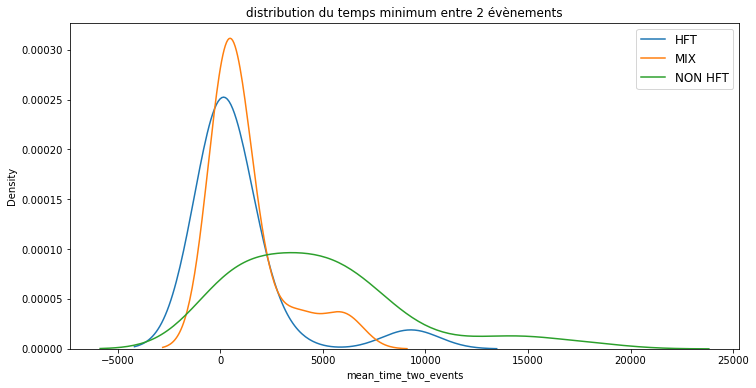

In [588]:
def plot_kde(x,y,titre):
    plt.figure(figsize=(12,6))
    sns.kdeplot(x[y=='HFT'],label='HFT')
    sns.kdeplot(x[y=='MIX'],label='MIX')
    sns.kdeplot(x[y=='NON HFT'],label='NON HFT')
    plt.legend(fontsize=12)
    plt.title(titre,fontsize=12)
plot_kde(df_train_dec['mean_time_two_events'],df_train_dec['type'],'distribution du temps minimum entre 2 évènements')

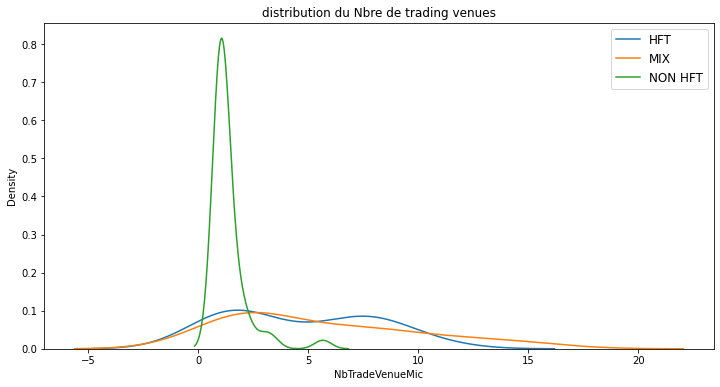

In [589]:
plot_kde(df_train_dec['NbTradeVenueMic'],df_train_dec['type'],'distribution du Nbre de trading venues')

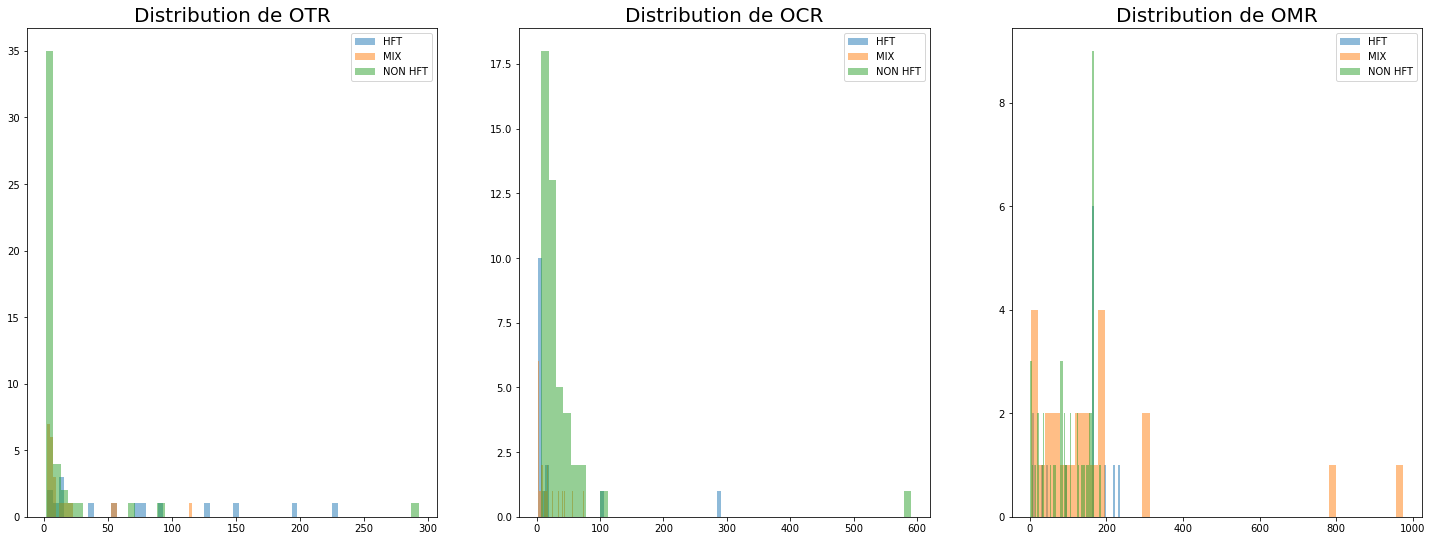

In [590]:
def plt_histogram(x,y):
    plt.hist(x[y=='HFT'],50,alpha=0.5,label='HFT')
    plt.hist(x[y=='MIX'],50,alpha=0.5,label='MIX')
    plt.hist(x[y=='NON HFT'],50,alpha=0.5,label='NON HFT')
    plt.legend()
    plt.show
def plt_histogram_final(liste_variables):
    plt.figure(figsize = (25,9))
    for i in range(1,4):
        plt.subplot(1,3,i)
        plt.title('Distribution de'+' '+liste_variables[i-1],fontsize=20)
        plt_histogram(df_train_dec[liste_variables[i-1]],df_train_dec['type'])
    
plt_histogram_final(['OTR','OCR','OMR'])

### <u>6- Features selection

In [591]:
#Comme 1ère étape , on va vérifier la corrélation des variables en utilisant la correlation map

In [592]:
corr =x_train.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,mean_lifetime_cancel,10_p_lifetime_cancel,med_lifetime_cancel,25_p_lifetime_cancel,75_p_lifetime_cancel,90_p_lifetime_cancel,max_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,NbSecondWithAtLeatOneTrade,moy_min_dt_TVi_TVj,moy_med_dt_TVi_TVj,moy_mean_dt_TVi_TVj
OTR,1.00,0.62,-0.13,-0.09,-0.27,-0.09,-0.13,-0.10,-0.24,-0.30,-0.26,-0.02,-0.01,-0.02,-0.02,-0.03,0.01,0.01,0.01,0.06,-0.07,-0.14,0.14,0.09,0.10,0.15,-0.01,-0.02,-0.03
OCR,0.62,1.00,-0.18,-0.07,-0.11,-0.07,-0.07,-0.07,-0.12,-0.13,-0.10,0.13,0.19,0.13,0.18,0.13,0.22,0.20,0.10,-0.18,-0.13,0.07,0.06,0.14,0.07,-0.18,-0.02,-0.01,-0.01
OMR,-0.13,-0.18,1.00,0.03,-0.01,0.02,-0.04,-0.00,-0.00,0.02,0.16,-0.10,-0.11,-0.09,-0.09,-0.09,-0.11,-0.10,0.03,0.42,0.13,-0.02,-0.20,-0.23,-0.20,0.14,-0.19,-0.18,-0.18
min_time_two_events,-0.09,-0.07,0.03,1.00,0.57,1.00,0.59,0.91,0.51,0.40,0.19,0.37,0.34,0.37,0.34,0.36,0.31,0.26,0.18,-0.14,-0.10,-0.11,0.09,0.05,0.08,-0.10,0.02,0.01,0.01
mean_time_two_events,-0.27,-0.11,-0.01,0.57,1.00,0.59,0.83,0.71,0.98,0.94,0.64,0.61,0.71,0.61,0.70,0.64,0.70,0.67,0.53,-0.27,-0.24,-0.24,0.23,0.31,0.28,-0.30,-0.03,-0.02,0.00
10_p_time_two_events,-0.09,-0.07,0.02,1.00,0.59,1.00,0.64,0.93,0.54,0.42,0.20,0.37,0.35,0.37,0.35,0.36,0.32,0.27,0.19,-0.14,-0.10,-0.11,0.09,0.06,0.08,-0.11,0.02,0.02,0.01
med_time_two_events,-0.13,-0.07,-0.04,0.59,0.83,0.64,1.00,0.85,0.83,0.66,0.37,0.33,0.39,0.33,0.37,0.34,0.39,0.38,0.28,-0.16,-0.17,-0.18,0.11,0.16,0.13,-0.18,0.03,0.04,0.05
25_p_time_two_events,-0.10,-0.07,-0.00,0.91,0.71,0.93,0.85,1.00,0.68,0.52,0.26,0.35,0.35,0.35,0.34,0.35,0.34,0.31,0.22,-0.15,-0.13,-0.14,0.09,0.08,0.09,-0.13,0.04,0.04,0.04
75_p_time_two_events,-0.24,-0.12,-0.00,0.51,0.98,0.54,0.83,0.68,1.00,0.92,0.62,0.59,0.66,0.60,0.66,0.62,0.65,0.62,0.53,-0.22,-0.15,-0.24,0.24,0.30,0.28,-0.22,-0.05,-0.04,-0.03
90_p_time_two_events,-0.30,-0.13,0.02,0.40,0.94,0.42,0.66,0.52,0.92,1.00,0.79,0.57,0.73,0.58,0.71,0.62,0.75,0.75,0.68,-0.25,-0.14,-0.30,0.17,0.27,0.24,-0.24,-0.08,-0.06,-0.05


    Plusieurs cases de la correlation map présentent de très fortes corrélations . Les paires fortement corrélées sont les suivantes : 

In [593]:
s=x_train.corr().unstack().sort_values(ascending=False).drop_duplicates()
s.where(s>0.9).dropna().drop(('OTR','OTR'))

10_p_lifetime_cancel  min_lifetime_cancel     0.999806
moy_min_dt_TVi_TVj    moy_med_dt_TVi_TVj      0.998630
10_p_time_two_events  min_time_two_events     0.998044
10_p_lifetime_cancel  25_p_lifetime_cancel    0.995312
25_p_lifetime_cancel  min_lifetime_cancel     0.993385
moy_mean_dt_TVi_TVj   moy_med_dt_TVi_TVj      0.990539
med_lifetime_cancel   mean_lifetime_cancel    0.989939
med_dt_TV1            min_dt_TV1              0.986625
moy_min_dt_TVi_TVj    moy_mean_dt_TVi_TVj     0.985421
75_p_lifetime_cancel  90_p_lifetime_cancel    0.980433
mean_lifetime_cancel  75_p_lifetime_cancel    0.977615
75_p_time_two_events  mean_time_two_events    0.975361
25_p_lifetime_cancel  med_lifetime_cancel     0.969085
mean_dt_TV1           med_dt_TV1              0.962421
mean_time_two_events  90_p_time_two_events    0.944956
75_p_lifetime_cancel  med_lifetime_cancel     0.944306
10_p_lifetime_cancel  med_lifetime_cancel     0.942624
med_lifetime_cancel   min_lifetime_cancel     0.937073
mean_lifet

####  <font color='red'><u>Commentaire</u></font> :  présence de corrélations allant jusqu'à 99% 
 #### Pour résoudre ce problème de corrélation et sélectionner les variables ,  On va utiliser la régression logistique + Lasso , en optimisant le degré de pénalité par la cross validation

In [594]:
# essayer la sélection avec l'hyperparamètre de défaut ( C=1 )
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1',multi_class='ovr',solver='liblinear'))
scaler = StandardScaler()
scaler.fit(x_train)  # standardiser la matrice des variables explicatives 

sel_.fit(scaler.transform(x_train), y_train) # entraîner le modèle pour la sélection des variables
sel_.get_support() # afficher la sélection
# les valeurs VRAI correspondent aux variables gardées et les variables FAUX correspondent aux variables supprimées 

array([ True,  True,  True, False, False,  True,  True,  True, False,
        True,  True,  True, False, False, False, False,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True, False,
       False,  True])

In [595]:
# optimisation de l'hyperparamètre C par la cross validation
import numpy as np
from sklearn.model_selection import cross_val_score
C= [x for x in np.linspace(0.1,5,20)]
cv_scores = []
for c in C:
    logistics_lasso = LogisticRegression(C=c, penalty='l1',multi_class='ovr',solver='liblinear')
    scores = cross_val_score(logistics_lasso,scaler.transform(x_train), y_train, cv=3) # cross validation
    cv_scores.append(scores.mean())

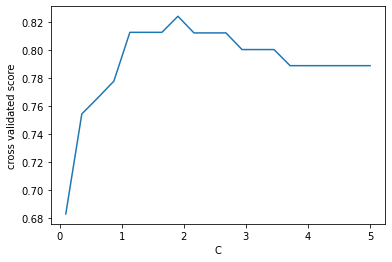

In [596]:
plt.plot(C, cv_scores)
plt.xlabel('C')
plt.ylabel('cross validated score')
plt.show()

In [597]:
print('le degré de pénalisation optimum est: ', C[np.array(cv_scores).argmax()] , 
      '. Il génère un score de ', np.array(cv_scores).max())

le degré de pénalisation optimum est:  1.905263157894737 . Il génère un score de  0.8238916256157637


In [598]:
# Pour l'hyperparamètre optimal = 1.9 , on a la sélection suivante : 
sel_ = SelectFromModel(LogisticRegression(C=1.9, penalty='l1',multi_class='ovr',solver='liblinear'))
sel_.fit(scaler.transform(x_train), y_train) 
sel_.get_support() # retourne les valeurs VRAI et FAUX 
x_train.columns[sel_.get_support()] # les variables gardés par le lasso sont les suivants

Index(['OTR', 'OCR', 'OMR', 'min_time_two_events', '10_p_time_two_events',
       '25_p_time_two_events', '75_p_time_two_events', '90_p_time_two_events',
       'max_time_two_events', 'min_lifetime_cancel', '90_p_lifetime_cancel',
       'NbTradeVenueMic', 'MaxNbTradesBySecond', 'MeanNbTradesBySecond',
       'min_dt_TV1', 'med_dt_TV1', 'NbSecondWithAtLeatOneTrade',
       'moy_mean_dt_TVi_TVj'],
      dtype='object')

In [599]:
print('nbre de variables explicatives total : ', len(x_train.columns))
print('nbre de variables explicatives gardées : ',len(x_train.columns[sel_.get_support()]))
print ('nbre de variables explicatives supprimées :' , len(x_train.columns)-len(x_train.columns[sel_.get_support()]))

nbre de variables explicatives total :  29
nbre de variables explicatives gardées :  18
nbre de variables explicatives supprimées : 11


In [600]:
x_train_final=x_train[x_train.columns[sel_.get_support()]]
x_train_final.head()  # Notre matrice de variables explicatives final 

,OTR,OCR,OMR,min_time_two_events,10_p_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,90_p_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,med_dt_TV1,NbSecondWithAtLeatOneTrade,moy_mean_dt_TVi_TVj
0,7.807554,34.600000,163.730280,8.951034,8.951034,8.951054,685.248281,2623.099829,2629.815306,150.194326,2629.815306,9.200000,17.400000,5.119288,87.691021,130.584267,39.000000,430.459508
1,5.291763,26.348230,163.796670,281.143544,285.624589,497.031552,10712.795325,23401.662768,37386.559638,6366.220501,28594.517919,1.948348,14.722523,1.476684,118.461499,400.064941,104.612012,796.776108
2,3.666667,9.142857,163.730280,1725.812961,1725.812961,1725.812961,27085.312114,33114.158286,33114.158286,29126.344504,29126.344504,1.000000,3.571429,2.428571,6455.785804,6578.318506,1.571429,613.857998
3,3.261453,11.372549,94.474854,341.188804,343.341275,348.091122,6998.170559,13771.469440,14749.875722,4899.629197,7526.619328,1.000000,2.705882,1.899160,3193.790743,4087.296235,3.470588,613.857998
4,9.888919,12.624458,163.730280,3669.775350,3669.775354,3705.061185,14333.335571,22125.586960,26159.785097,12149.436822,22112.822545,1.419753,5.769547,1.862654,1173.328002,1545.688415,13.646091,1609.667081


<u><font color='red'>Note:</font></u> On n'a pas encore utilisé les données de test et la cross validation pour la sélection de l'hyperparamètre a été faite en splittant le training set . On ne va toucher au testing set qu'à la fin pour évaluer la performance du(des) modèle(s) final(aux)

 ### <u>7- Sélection des modèles de classification et optimisation des hyperparamètres 

#### <u>Modèle 1 :SVM</u>

Puisqu'il s'agit d'un problème de multi-classification ( 3 classes )  , le SVM standard n'est pas applicable car il est naturellement un classificateur binaire . Pour pouvoir l'appliquer dans notre modèle , on va l'ajuster par la stratégie OVR : One Over The Rest qui remédie au problème de la classification binaire . 

In [601]:
# D'abord , les variables non sélectionnées dans le x_train doivent aussi être supprimés du x_test 
x_test_final=x_test[x_test.columns[sel_.get_support()]]
#standardisation des variables explicatives
scaler.fit(x_train_final)
# on va essayer d'abord avec l'hyperparamètre de défaut C=1
model = SVC(kernel='linear', C=1, random_state=42,decision_function_shape='ovr')
model.fit(scaler.transform(x_train_final),y_train)
y_pred=model.predict(scaler.transform(x_test_final))
print('score du modèle : ' , round(accuracy_score(y_test, y_pred, normalize=True),3))

score du modèle :  0.88


In [602]:
# optimisation de l'hyperparamètre
C = [x for x in np.linspace(0.01,2,20)]
cv_scores=[]
for c in C:
    model = SVC(kernel='rbf', C=c, random_state=42,decision_function_shape='ovo')
    scores = cross_val_score(model,scaler.transform(x_train_final), y_train, cv=5) 
    cv_scores.append(scores.mean())

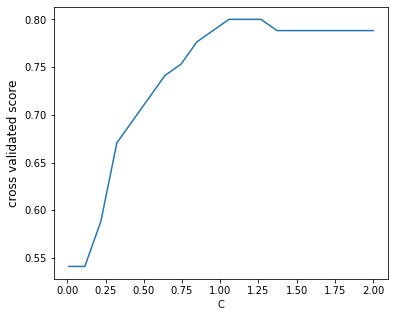

In [603]:
#plotter le Rtat de l'optimisation
plt.figure(figsize=(6,5))
plt.plot(C, cv_scores)
plt.xlabel('C')
plt.ylabel('cross validated score',fontsize=12)
plt.show()

In [604]:
print('le degré de régularisation optimum est: ', round(C[np.array(cv_scores).argmax()],2) , 
      '. Il génère un score de cross validation de ', round(np.array(cv_scores).max(),2))

le degré de régularisation optimum est:  1.06 . Il génère un score de cross validation de  0.8


In [605]:
# Avec l'hyperparamètre sélectionné , évaluons le modèle maintenant sur le testing set 
SVM = SVC(kernel='rbf', C=1.06, random_state=42,decision_function_shape='ovo')
SVM.fit(scaler.transform(x_train_final),y_train)
y_pred=SVM.predict(scaler.transform(x_test_final))
print ( "l'accuracy du modèle est : " , round(accuracy_score(y_test, y_pred, normalize=True),3))

l'accuracy du modèle est :  0.892


In [606]:
# Pour améliorer le modèle , essayons avec les différents kernels 
# Pour cela , on va optimiser le couple de paramètres ( kernel , C) par la cross validation 
C = [x for x in np.linspace(0.01,1,20)]
kernel=['linear','poly','sigmoid','rbf']
cv_scores={}
for c in C:
    for k in kernel:
        model = SVC(kernel=k, C=c, random_state=42,decision_function_shape='ovo')
        scores = cross_val_score(model,scaler.transform(x_train_final), y_train, cv=5) 
        cv_scores[(k,c)]=scores.mean()
#cv_scores est un dictionnaire de la forme suivante : { ('linear',0.01) : 0.67 , ('poly',0.01): 0.82 ....... } avec les clés 
# étant des tuples formés par les paramètres à optimiser et les valeurs étant les scores cross validés correspondants .

In [607]:
print('le couple qui maximise le score cross validé est :' , max(cv_scores,key=cv_scores.get) )

le couple qui maximise le score cross validé est : ('linear', 0.21842105263157896)


In [608]:
model = SVC(kernel='linear', C=0.21, random_state=42,decision_function_shape='ovr')
model.fit(scaler.transform(x_train_final),y_train)
y_pred=model.predict(scaler.transform(x_test_final))
print('score du modèle : ' , round(accuracy_score(y_test, y_pred, normalize=True),3) )

score du modèle :  0.867


 Pour le meilleur couple (kernel , c) = ('linear' , 0.21 ) , l'accuracy finale du SVM est 86.7% . 

In [609]:
# Evaluons le modèle par d'autres metrics : 
def conf_matrix_class_report(y_test,y_pred,rtat_évaluation):
    y_test_decoded=y_test.replace({0:'HFT', 1:'NON HFT', 2: 'MIX'})
    y_pred_decoded=np.array(pd.Series(y_pred).replace({0:'HFT', 1:'NON HFT', 2: 'MIX'}))
    if rtat_évaluation=='confusion_matrix' :
        rtat=pd.crosstab(y_test_decoded,y_pred_decoded,rownames=['Actual'],colnames=['Predicted'])
    elif rtat_évaluation=='classification_report':
        rtat=classification_report(y_test_decoded,y_pred_decoded)
    print(rtat)

In [610]:
conf_matrix_class_report(y_test,y_pred,'confusion_matrix')

Predicted  HFT  MIX  NON HFT
Actual                      
HFT          9    2        4
MIX          1   20        3
NON HFT      0    1       43


In [611]:
# Détail du score : 43 NON HFT correctement classifiés , 19 MIX correctement classifiés , 8 HFT correctement classifié soit un
# total de 72 observations correctes parmi 83 . 

In [612]:
conf_matrix_class_report(y_test,y_pred,'classification_report')

              precision    recall  f1-score   support

         HFT       0.90      0.60      0.72        15
         MIX       0.87      0.83      0.85        24
     NON HFT       0.86      0.98      0.91        44

    accuracy                           0.87        83
   macro avg       0.88      0.80      0.83        83
weighted avg       0.87      0.87      0.86        83



 <u>**<font color='red'>Cross validation pour un score moyen plus représentatif</font>**</u>

In [613]:
# on effectue la cross validation sur tout le dataset 
x=pd.concat([x_train,x_test],axis=0)
y=pd.concat([y_train,y_test],axis=0)
scores = cross_val_score(model,x, y, cv=5) 
scores.mean()

0.7607843137254903

#### <u>Modèle 2: KNN </u>

In [614]:
knn = KNeighborsClassifier(n_neighbors=6)
scaler.fit(x_train_final) # standardisation des variables explicatives
knn.fit(scaler.transform(x_train_final),y_train)
y_pred=knn.predict(scaler.transform(x_test_final))
print('score du modèle est : ' ,round(accuracy_score(y_test, y_pred, normalize=True),3))

score du modèle est :  0.783


In [615]:
# optimisation de l'hyperparamètre n_neighbors par la cross validation
neighbors = [x for x in range(1,50)]
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn,scaler.transform(x_train_final), y_train, cv=5) 
    cv_scores.append(scores.mean())

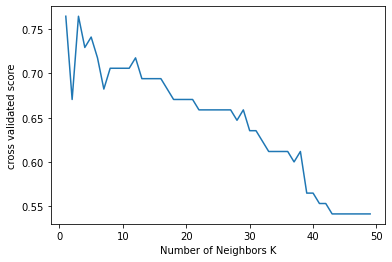

In [616]:
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('cross validated score')
plt.show()

In [617]:
print('le nbre de voisins optimal est : ', neighbors[np.array(cv_scores).argmax()] , 
      '. Il génère un score de cross validation de ', np.array(cv_scores).max())

le nbre de voisins optimal est :  3 . Il génère un score de cross validation de  0.7647058823529412


In [618]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(scaler.transform(x_train_final),y_train)
y_pred=knn.predict(scaler.transform(x_test_final))
accuracy_score(y_test, y_pred, normalize=True)

0.8554216867469879

In [619]:
conf_matrix_class_report(y_test,y_pred,'confusion_matrix')

Predicted  HFT  MIX  NON HFT
Actual                      
HFT         11    2        2
MIX          3   17        4
NON HFT      1    0       43


In [620]:
# 43 NON HFT correctement classifiés , 17 MIX correctement classifiés , 11 HFT correctement classifiés soit un
# total de 71 observations correctes parmi 83. 

In [621]:
conf_matrix_class_report(y_test,y_pred,'classification_report')

              precision    recall  f1-score   support

         HFT       0.73      0.73      0.73        15
         MIX       0.89      0.71      0.79        24
     NON HFT       0.88      0.98      0.92        44

    accuracy                           0.86        83
   macro avg       0.84      0.81      0.82        83
weighted avg       0.86      0.86      0.85        83



 <u>**<font color='red'>Cross validation pour un score moyen plus représentatif</font>**</u>

In [622]:
scores = cross_val_score(knn,x, y, cv=5) 
scores.mean()

0.7679144385026737

#### <u>Modèle 3: Linear Discriminant analysis </u>

In [623]:
# choix du paramètre solver
sol= ['svd', 'lsqr', 'eigen']
cv_scores = []
for i in sol:
    LDA = LinearDiscriminantAnalysis(solver=i)
    scores = cross_val_score(LDA,x_train_final, y_train, cv=5) 
    cv_scores.append(scores.mean())

In [624]:
cv_scores

[0.7176470588235293, 0.7176470588235293, 0.7176470588235293]

In [625]:
# Evaluer la performance du modèle sur le testing set 
LDA = LinearDiscriminantAnalysis(solver='eigen')
LDA.fit(x_train_final,y_train)
y_pred=LDA.predict(x_test_final)
print('score du modèle est : ' , round(accuracy_score(y_test, y_pred, normalize=True),3))

score du modèle est :  0.843


In [626]:
conf_matrix_class_report(y_test,y_pred,'confusion_matrix')

Predicted  HFT  MIX  NON HFT
Actual                      
HFT          8    2        5
MIX          1   20        3
NON HFT      1    1       42


In [627]:
conf_matrix_class_report(y_test,y_pred,'classification_report')

              precision    recall  f1-score   support

         HFT       0.80      0.53      0.64        15
         MIX       0.87      0.83      0.85        24
     NON HFT       0.84      0.95      0.89        44

    accuracy                           0.84        83
   macro avg       0.84      0.77      0.79        83
weighted avg       0.84      0.84      0.84        83



 <u>**<font color='red'>Cross validation pour un score moyen plus représentatif</font>**</u>

In [628]:
scores = cross_val_score(LDA,x, y, cv=5) 
scores.mean()

0.8333333333333334

#### <u>Modèle 4: Naive Bayes </u>

In [629]:
# caractéristiques du modèle : features indépendants / marche mieux que les autres classifiers pour des datasets de taille 
# réduite ( cas de notre dataset qui s'est considérablemnt réduit après le regroupement des traders ) 
gnb = GaussianNB()
gnb.fit(x_train_final, y_train)
y_pred=gnb.predict(x_test_final)
y_pred_train=gnb.predict(x_train_final)
print('score du modèle sur le training set est : ' , round(accuracy_score(y_train, y_pred_train, normalize=True),3))
print('score du modèle sur le testing set est : ' , round(accuracy_score(y_test, y_pred, normalize=True),3))

score du modèle sur le training set est :  0.706
score du modèle sur le testing set est :  0.651


In [630]:
conf_matrix_class_report(y_test,y_pred,'classification_report')

              precision    recall  f1-score   support

         HFT       0.52      0.73      0.61        15
         MIX       0.56      0.79      0.66        24
     NON HFT       0.86      0.55      0.67        44

    accuracy                           0.65        83
   macro avg       0.65      0.69      0.64        83
weighted avg       0.71      0.65      0.65        83



 <u>**<font color='red'>Cross validation pour un score moyen plus représentatif</font>**</u>

In [631]:
scores = cross_val_score(gnb,x, y, cv=5) 
scores.mean()

0.5944741532976827

 ### <u>8- Prédiction sur le testing set donné de l'AMF

In [632]:
test=pd.read_csv('AMF_test_X.csv')
test=test.drop(['Index','Share','Day'],axis=1)
test=moy_tvi_tvj(test)
test[['OMR','OTR']]=test[['OMR','OTR']].fillna(moy_stockés1)
test[lst_names]=test[lst_names].fillna(moy_stockés2)
test=test.groupby(['Trader']).mean()
test=test[test.columns[sel_.get_support()]]
y_pred=LDA.predict(test)
y_pred_df=pd.DataFrame(y_pred)
y_pred_df.head()
test1=test.reset_index()
trader=test1[['Trader']]
trader['Type']=y_pred_df
trader1=trader.replace({'Type':{0:'HFT',1:'NON HFT',2:'MIX'}})

C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [633]:
trader1.head()

,Trader,Type
0,Adelaide,NON HFT
1,Alana,NON HFT
2,Alcmene,NON HFT
3,Alice,HFT
4,Alices Sister,NON HFT


In [634]:
trader1.to_csv('résultat3.csv',index=False)